This notebook provides codes for generating all plots for knee osteoarthritis assessment using COBRA scores calculated from MRI images. It takes saved COBRA score and produces plots in **Quantifying Impairment and Disease Severity Using AI Models Trained on Healthy Subjects** by Boyang Yu*, Aakash Kaku*, Kangning Liu*, Avinash Parnandi, Emily Fokas, Anita Venkatesan, Natasha Pandit, Rajesh Ranganath, Heidi Schambra and Carlos Fernandez-Granda \[* - Equal Contribution\].





In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import matplotlib.patches as mpatches
import seaborn as sns
import json
# from nifti import NiftiImage

In [38]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

def read_arr(x):
    x = str(x)
    try:
        s = x.replace('\n','').replace('    ',' ').replace('   ',' ').replace('  ',' ').replace(' ',', ')
        s = s.replace(', ]', ']')
        s = s.replace('.,', '.0,')
        l = json.loads(s)
        arr = np.array(l)/6
    except Exception as e: 
        print(e)
        print(s)
        print(l)
        print(arr)
    return arr

In [39]:
impaired_df = pd.read_csv('knee_OA_confidence.csv')

meta = pd.read_csv('/scratch/by2026/OAI/kneeOA_data_split.csv')
meta['KL_right_knee'] = meta['KL_right_knee'].astype('int')
impaired_df['sub'] = impaired_df['sub'].astype('int')

merged = meta[['id','KL_right_knee']].merge(impaired_df,left_on='id',right_on='sub')
merged = merged[merged.split=='test']
merged['cartilage_prob_2'] = merged['cartilage_prob_2'].map(read_arr)
merged['cartilage_prob_4'] = merged['cartilage_prob_4'].map(read_arr)



# Averaging model confidence yields a discriminative subject-level metric



In [50]:
np.random.seed(22)

HC_sub = np.random.choice(merged[merged.KL_right_knee==0]['id'].unique(), 1)
HAR_sub = np.random.choice(merged[merged.KL_right_knee!=0]['id'].unique(), 1)

HC_sub, HAR_sub

(array([9973322]), array([9277154]))

In [51]:
merged[merged.id==HAR_sub[0]]

,id,KL_right_knee,sub,split,confidence_0_mean,confidence_1_mean,confidence_2_mean,confidence_3_mean,confidence_4_mean,cartilage_prob_2,cartilage_prob_4
194,9277154,4,9277154,test,0.991121,0.950829,0.785009,0.966312,0.777361,"[0.82965533, 0.5078217183333333, 0.60116505666...","[0.8901310766666667, 0.49060455999999997, 0.53..."


7.1112295520518085
7.1112295520518085


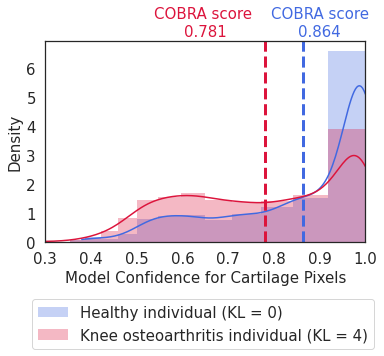

In [52]:
fig, axes = plt.subplots(1,1,figsize=(5.5,5.5))
sns.set(style='white')

m = merged[merged.id==HC_sub[0]][['cartilage_prob_2','cartilage_prob_4']].apply(lambda x: np.mean(x[0]+x[1]),axis=1).values[0]/2.
plt.axvline(x = m, linestyle='--', linewidth=3, color = 'royalblue',label = '')
sns.histplot(np.hstack(np.hstack(merged[merged.id==HC_sub[0]][['cartilage_prob_2','cartilage_prob_4']].values)),
             bins=np.logspace(start=np.log10(0.001), stop=np.log10(1.), num=80+1),
             #bins=20,log_scale=False,
             alpha=0.3, kde=True, stat='density',color = 'royalblue', 
             label='Healthy individual (KL = 0)'.format(m))
print(plt.gca().get_ylim()[1]+0.2)
#plt.xscale('log')
plt.annotate('COBRA score\n{:.3f}'.format(m), xy=(0.9, plt.gca().get_ylim()[1]+0.2),#xytext=(m,11),
             #arrowprops={"width":3,"headwidth":10,'headlength':10, "color":'deepskyblue',},
             horizontalalignment='center',color = 'royalblue', fontsize=15, annotation_clip=False)

m = merged[merged.id==HAR_sub[0]][['cartilage_prob_2','cartilage_prob_4']].apply(lambda x: np.mean(x[0]+x[1]),axis=1).values[0]/2.
plt.axvline(x = m,  linestyle='--', linewidth=3, color = 'crimson',  label = '')
sns.histplot(np.hstack(np.hstack(merged[merged.id==HAR_sub[0]][['cartilage_prob_2','cartilage_prob_4']].values)),
             bins=np.logspace(start=np.log10(0.001), stop=np.log10(1.), num=80+1),
             #bins=20,log_scale=False,
             alpha=0.3, kde=True, stat='density',color = 'crimson', 
             label='Knee osteoarthritis individual (KL = 4)'.format(m))
print( plt.gca().get_ylim()[1]+0.2)
plt.annotate('COBRA score \n{:.3f}'.format(m), xy=(0.65, plt.gca().get_ylim()[1]+0.2),#xytext=(0.4,1.5),
             #arrowprops={"width":3,"headwidth":10,'headlength':10, "color":'tomato',},
             horizontalalignment='center',color = 'crimson', fontsize=15, annotation_clip=False)


plt.ylabel('Density',fontsize=15)
plt.xlabel('Model Confidence for Cartilage Pixels',fontsize=15)

plt.xlim(0.3, 1.)
plt.legend(fontsize=15,bbox_to_anchor=(1.05,-0.25))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.savefig('knee_individual_hist.pdf')




# Correlation between the COBRA score and clinical assessment

We first compare COBRA against Kellgren and Lawrence (KL) grade on a test cohort consisting of the remaining 57 healthy individuals and 378 stroke patients. 


###  The COBRA score exploits clinically-relevant structure - Confidence in cartilage segmentation

Note that cartilage corresponds with segmentation class 2 and class 4

In [4]:
data_1 = np.hstack(merged[merged.KL_right_knee==4][['confidence_2_mean','confidence_4_mean']].values)
data_2 = np.hstack(merged[merged.KL_right_knee==3][['confidence_2_mean','confidence_4_mean']].values)
data_3 = np.hstack(merged[merged.KL_right_knee==2][['confidence_2_mean','confidence_4_mean']].values)
data_4 = np.hstack(merged[merged.KL_right_knee==1][['confidence_2_mean','confidence_4_mean']].values)
data_5 = np.hstack(merged[merged.KL_right_knee==0][['confidence_2_mean','confidence_4_mean']].values)
data = [data_1, data_2, data_3, data_4, data_5]



<ipython-input-5-81ae60d8cdb0>:39: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,


Correlation coefficient = -0.644
 (95% C.I. [-0.696,-0.585])


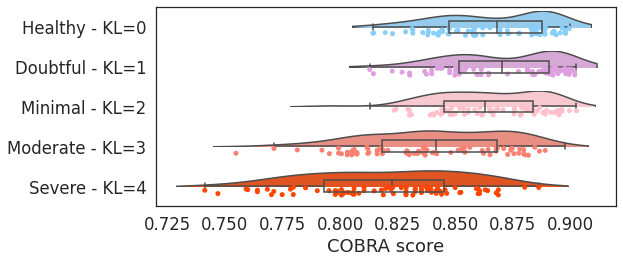

In [5]:

fig = plt.figure(figsize =(9,4)) #fig 3
# fig = plt.figure(figsize =(7,4)) #fig 5
data_df = pd.DataFrame({'label':['KL=4']*data_1.shape[0] +\
                                ['KL=3']*data_2.shape[0] +\
                                ['KL=2']*data_3.shape[0] +\
                                ['KL=1']*data_4.shape[0] +\
                                ['KL=0']*data_5.shape[0],
                        'confidence':[x for xs in data for x in xs]
                       })
data_df.sort_values('label',ascending=True,inplace=True)
# sns.set_style('white')
#palette = {"KL=0": "lightgray","KL=1": "peachpuff", "KL=2": "orange", "KL=3": "coral", "KL=4":"sienna"}
palette = {"KL=0": "lightskyblue","KL=1": "plum", "KL=2": "pink", "KL=3": "salmon", "KL=4":"orangered"}
palette_density = {"KL=0": "lightgray","KL=1": "lightgray", "KL=2": "lightgray", "KL=3": "lightgray", "KL=4":"lightgray"}

sns.set(font_scale = 1.5,style='white')
ax = sns.violinplot(y="label", x="confidence", data=data_df[data_df.confidence>0.7],
                    palette=palette,cut=1,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="label", x="confidence", data=data_df, saturation=1, showfliers=False, palette=palette,
            width=0.3, whis=1, boxprops={'zorder': 3,'facecolor':'none'}, ax=ax)

old_len_collections = len(ax.collections)
data_sampled = data_df.groupby('label').agg({'confidence':lambda x: list(np.random.choice(np.hstack(x.values),size=80))})
data_sampled.reset_index(drop=False,inplace=True)

sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,
              size=5, jitter=0.1, ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim([0.72,0.92])# full in the plot
ax.set_ylim(ylim)
plt.xlabel('COBRA score')
plt.ylabel('')
plt.yticks(['KL=0', 'KL=1', 'KL=2','KL=3','KL=4'], ['Healthy - KL=0', 'Doubtful - KL=1', 'Minimal - KL=2', 'Moderate - KL=3','Severe - KL=4'])
r, p, lo, hi = pearsonr_ci(merged['KL_right_knee'],merged[[f'confidence_2_mean',f'confidence_4_mean']].apply(np.mean,axis=1))

print("Correlation coefficient = {:.3f}\n (95% C.I. [{:.3f},{:.3f}])".format(r,lo,hi))

plt.tight_layout()
# plt.savefig(f'./OAI_cartilage_group_plot.pdf')


Correlation coefficient = -0.644 
(95% C.I. [-0.696,-0.585])


<ipython-input-6-5352b0a727d4>:21: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,


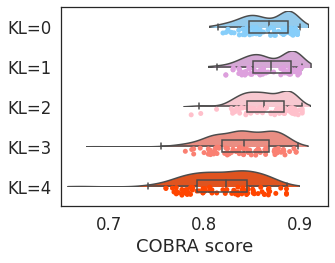

In [6]:
fig = plt.figure(figsize =(5,4))

sns.set(font_scale = 1.5,style='white')
ax = sns.violinplot(y="label", x="confidence", data=data_df,
                    palette=palette, cut=1,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="label", x="confidence", data=data_df, saturation=1, showfliers=False, palette=palette,
            width=0.3, boxprops={'zorder': 3,'facecolor':'none'}, ax=ax)

old_len_collections = len(ax.collections)
data_sampled = data_df.groupby('label').agg({'confidence':lambda x: list(np.random.choice(np.hstack(x.values),size=80))})
data_sampled.reset_index(drop=False,inplace=True)

sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,
              size=5, jitter=0.1, ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim([0.65,0.93])
ax.set_ylim(ylim)
plt.xlabel('COBRA score')
plt.ylabel('')
plt.yticks(['KL=0', 'KL=1', 'KL=2','KL=3','KL=4'], ['KL=0','KL=1','KL=2','KL=3','KL=4'])
r, p, lo, hi = pearsonr_ci(merged['KL_right_knee'],merged[[f'confidence_2_mean',f'confidence_4_mean']].apply(np.mean,axis=1))

print("Correlation coefficient = {:.3f} \n(95% C.I. [{:.3f},{:.3f}])".format(r,lo,hi))
plt.tight_layout()
# plt.savefig(f'./OAI_cartilage_group_plot_small.pdf')


###  The COBRA score exploits clinically-relevant structure - Confidence in bone segmentation

Note that bone corresponds with segmentation class 1 and class 3

<ipython-input-7-b6be39991d87>:38: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,


Correlation coefficient = -0.426 
(95% C.I. [-0.500,-0.346])


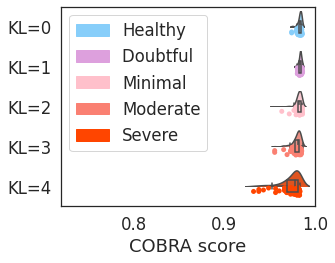

In [7]:
fig = plt.figure(figsize =(5,4))

data_1 = np.hstack(merged[merged.KL_right_knee==4][['confidence_1_mean','confidence_3_mean']].apply(np.mean,axis=1).values)
data_2 = np.hstack(merged[merged.KL_right_knee==3][['confidence_1_mean','confidence_3_mean']].apply(np.mean,axis=1).values)
data_3 = np.hstack(merged[merged.KL_right_knee==2][['confidence_1_mean','confidence_3_mean']].apply(np.mean,axis=1).values)
data_4 = np.hstack(merged[merged.KL_right_knee==1][['confidence_1_mean','confidence_3_mean']].apply(np.mean,axis=1).values)
data_5 = np.hstack(merged[merged.KL_right_knee==0][['confidence_1_mean','confidence_3_mean']].apply(np.mean,axis=1).values)
data = [data_1, data_2, data_3, data_4, data_5]

data_df = pd.DataFrame({'label':['KL=4']*data_1.shape[0] +\
                                ['KL=3']*data_2.shape[0] +\
                                ['KL=2']*data_3.shape[0] +\
                                ['KL=1']*data_4.shape[0] +\
                                ['KL=0']*data_5.shape[0],
                        'confidence':[x for xs in data for x in xs]
                       })
data_df.sort_values('label',ascending=True,inplace=True)

sns.set(font_scale = 1.5,style='white')
ax = sns.violinplot(y="label", x="confidence", data=data_df,
                    palette=palette,
                    scale="width", inner=None, label='label')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="label", x="confidence", data=data_df, saturation=1, showfliers=False, palette=palette,
            width=0.3, boxprops={'zorder': 3,'facecolor':'none'}, ax=ax)

old_len_collections = len(ax.collections)
data_sampled = data_df.groupby('label').agg({'confidence':lambda x: list(np.random.choice(np.hstack(x.values),size=80))})
data_sampled.reset_index(drop=False,inplace=True)

sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,
              size=5, jitter=0.1, ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim([0.72,1])
ax.set_ylim(ylim)
plt.xlabel('COBRA score')
plt.ylabel('')
plt.yticks(['KL=0', 'KL=1', 'KL=2','KL=3','KL=4'], ['KL=0','KL=1','KL=2','KL=3','KL=4'])
r, p, lo, hi = pearsonr_ci(merged['KL_right_knee'],merged[[f'confidence_1_mean',f'confidence_3_mean']].apply(np.mean,axis=1))
print("Correlation coefficient = {:.3f} \n(95% C.I. [{:.3f},{:.3f}])".format(r,lo,hi))

fake_handles = [mpatches.Patch(color='lightskyblue'),
                    mpatches.Patch(color='plum'),
                    mpatches.Patch(color='pink'),
                    mpatches.Patch(color='salmon'),
                    mpatches.Patch(color='orangered'),
                   ]
label = ['Healthy', 'Doubtful ', 'Minimal', 'Moderate','Severe']
ax.legend(fake_handles, label)
plt.tight_layout()

# plt.savefig(f'./OAI_bone_group_plot.pdf')


###  The COBRA score exploits clinically-relevant structure - Confidence in bone segmentation

Note that we exclude the background (class 0)

Correlation coefficient = -0.634
 (95% C.I. [-0.687,-0.575])


<ipython-input-8-ca848a3c9f44>:37: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,


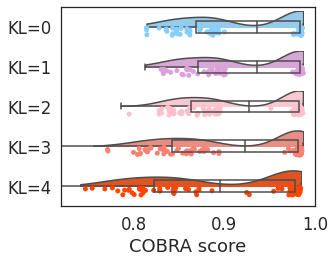

In [8]:
fig = plt.figure(figsize =(5,4))

data_1 = np.hstack(merged[merged.KL_right_knee==4][['confidence_1_mean','confidence_3_mean', 'confidence_2_mean','confidence_4_mean']].values)
data_2 = np.hstack(merged[merged.KL_right_knee==3][['confidence_1_mean','confidence_3_mean', 'confidence_2_mean','confidence_4_mean']].values)
data_3 = np.hstack(merged[merged.KL_right_knee==2][['confidence_1_mean','confidence_3_mean', 'confidence_2_mean','confidence_4_mean']].values)
data_4 = np.hstack(merged[merged.KL_right_knee==1][['confidence_1_mean','confidence_3_mean', 'confidence_2_mean','confidence_4_mean']].values)
data_5 = np.hstack(merged[merged.KL_right_knee==0][['confidence_1_mean','confidence_3_mean', 'confidence_2_mean','confidence_4_mean']].values)
data = [data_1, data_2, data_3, data_4, data_5]


data_df = pd.DataFrame({'label':['KL=4']*data_1.shape[0] +\
                                ['KL=3']*data_2.shape[0] +\
                                ['KL=2']*data_3.shape[0] +\
                                ['KL=1']*data_4.shape[0] +\
                                ['KL=0']*data_5.shape[0],
                        'confidence':[x for xs in data for x in xs]
                       })
data_df.sort_values('label',ascending=True,inplace=True)
sns.set(font_scale = 1.5,style='white')
ax = sns.violinplot(y="label", x="confidence", data=data_df[data_df.confidence>0.7],
                    palette=palette,cut=0,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="label", x="confidence", data=data_df, saturation=1, showfliers=False, palette=palette,
            width=0.3, boxprops={'zorder': 3,'facecolor':'none'}, ax=ax)

old_len_collections = len(ax.collections)
data_sampled = data_df.groupby('label').agg({'confidence':lambda x: list(np.random.choice(np.hstack(x.values),size=80))})
data_sampled.reset_index(drop=False,inplace=True)

sns.stripplot(y="label", x="confidence", data=data_sampled.explode('confidence'), palette=palette,
              size=5, jitter=0.1, ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim([0.72,1])
ax.set_ylim(ylim)
plt.xlabel('COBRA score')
plt.ylabel('')

plt.yticks(['KL=0', 'KL=1', 'KL=2','KL=3','KL=4'], ['KL=0','KL=1','KL=2','KL=3','KL=4'])
r, p, lo, hi = pearsonr_ci(merged['KL_right_knee'],
                           merged[[f'confidence_1_mean',f'confidence_3_mean','confidence_2_mean','confidence_4_mean']].apply(np.mean,axis=1))
print("Correlation coefficient = {:.3f}\n (95% C.I. [{:.3f},{:.3f}])".format(r,lo,hi))
plt.tight_layout()
# plt.savefig(f'./OAI_cartilage_and_bone_group_plot.pdf')

